In [1]:
import numpy as np
import keras
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import cv2
import os
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [2]:
x_train_path = './Training/original_retinal_images/'
y_train_path = './Training/blood_vessel_segmentation_masks/'
x_test_path = './Test/original_retinal_images/'
y_test_path = './Test/blood_vessel_segmentation_masks/'

train_masks_path = './Training/background_masks/'
test_masks_path = './Test/background_masks/'

In [3]:
def read_data(path):
    image_names = sorted(os.listdir(path))
    #print(image_names)
    l = []
    for i in range(len(image_names)):
        tmp = cv2.imread(path + image_names[i], 0)
        l.append(tmp)

    return np.asanyarray(l)

In [4]:
x_train = read_data(x_train_path)
y_train = read_data(y_train_path)
x_test = read_data(x_test_path)
y_test = read_data(y_test_path)

train_masks = read_data(train_masks_path)
test_masks = read_data(test_masks_path)

x_train = np.expand_dims(x_train, axis=3)
y_train = np.expand_dims(y_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
y_test = np.expand_dims(y_test, axis=3)
train_masks = np.expand_dims(train_masks, axis=3)
test_masks = np.expand_dims(test_masks, axis=3)


In [5]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, train_masks.shape, test_masks.shape)

(20, 512, 512, 1) (20, 512, 512, 1) (20, 512, 512, 1) (20, 512, 512, 1) (20, 512, 512, 1) (20, 512, 512, 1)


In [6]:
def unet(input_size = (512,512,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal', data_format='channels_last')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
    #conv11 = keras.layers.Softmax()(conv10)
    model = Model(input = inputs, output = conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

    return model

In [7]:
model = unet()

C:\Users\Kuo SHI\Anaconda3\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`


In [8]:
model.load_weights('model_infinity.hdf5')

In [9]:
tmp = model.predict(x_test)
tmp = cv2.bitwise_and(tmp, tmp, mask=test_masks)

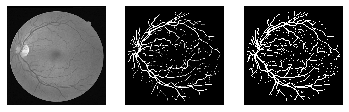

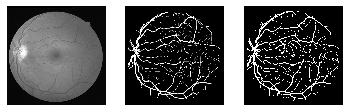

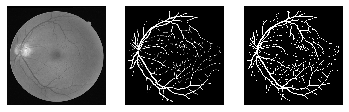

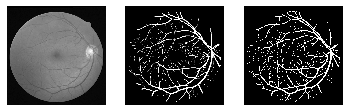

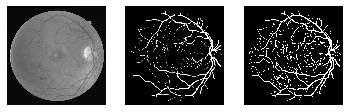

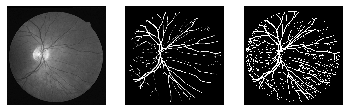

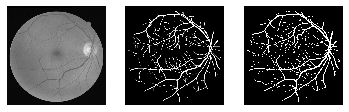

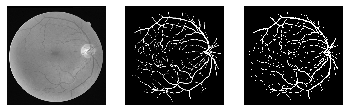

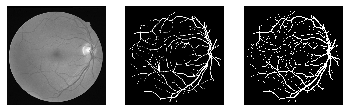

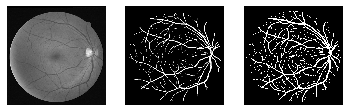

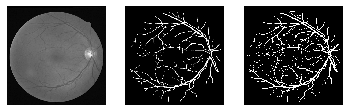

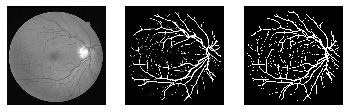

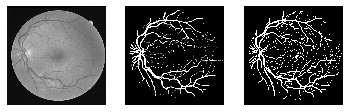

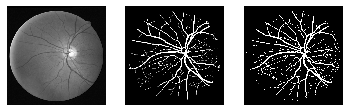

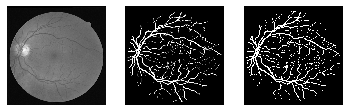

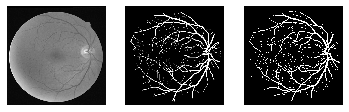

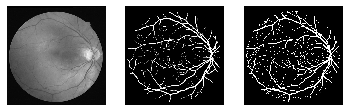

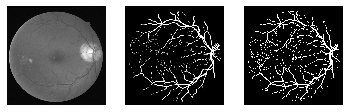

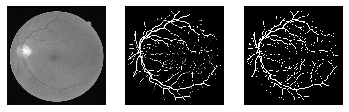

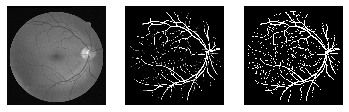

In [10]:
for i in range(len(x_test)):
    f = plt.figure()
    f.add_subplot(1,3, 1)
    plt.imshow(x_test[i].reshape((512,512)), cmap = 'gray')
    plt.axis('off')
    f.add_subplot(1,3, 2)
    plt.imshow(y_test[i].reshape((512,512)), cmap = 'gray')
    plt.axis('off')
    f.add_subplot(1,3, 3)
    plt.imshow(tmp[i].reshape((512,512)), cmap = 'gray')
    plt.axis('off')
    plt.show(block=True)

In [54]:
'''
for i in range(len(tmp)):
    plt.imsave("./Test/predictions/"+f"{100+i}_predict.png",tmp[i].reshape((512,512)),cmap='gray')
for i in range(len(y_test)):
    plt.imsave("./Test/predictions/"+f"{100+i}_ground.png",y_test[i].reshape((512,512)),cmap='gray')
'''

'\nfor i in range(len(tmp)):\n    plt.imsave("./Test/predictions/"+f"{100+i}_predict.png",tmp[i].reshape((512,512)),cmap=\'gray\')\nfor i in range(len(y_test)):\n    plt.imsave("./Test/predictions/"+f"{100+i}_ground.png",y_test[i].reshape((512,512)),cmap=\'gray\')\n'

In [11]:
def normal(y_true, y_pred):
    y_pred = y_pred.flatten()
    y_true = y_true.flatten()
    if y_pred.max() > 1:
        y_pred = y_pred / 255
    if y_true.max() > 1:
        y_true = y_true / 255
    y_pred[y_pred > 0.5] = 1
    y_pred[y_pred <= 0.5] = 0
    y_true[y_true > 0.5] = 1
    y_true[y_true <= 0.5] = 0
    return y_true, y_pred

In [12]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
accuracy_list = []
tn, fp, fn, tp = 0, 0, 0, 0
for i in range(len(tmp)):
    a, b = normal(y_test[i], tmp[i])
    tn2, fp2, fn2, tp2 = confusion_matrix(a,b).ravel()
    tn += tn2
    fp += fp2
    fn += fn2
    tp += tp2
    accuracy_list.append(accuracy_score(a, b))

In [13]:
tn, fp, fn, tp

(4592261, 192394, 72891, 385334)

In [14]:
accuracy_list.index(max(accuracy_list))

18

In [16]:
print("Unet: \n")

# Fraction of the true object that is correctly segmented
Sensitivity = tp / (tp + fn)
print("Sensitivity: ", Sensitivity)
# Fraction of the true background that is correctly segmented
Specificity = tn / (tn + fp)
print("Specificity: ", Specificity)
# Fraction of the segmented object that is correctly segmented
Precision = tp / (tp + fp)
print("Precision: ", Precision)
# Fraction of the true object that is correctly segmented
Recall = tp / (tp + fn)
print("Recall: ", Recall)
# Harmonic mean ofprecision and recall
F_measure = 2 * (Recall * Precision) / (Recall + Precision)
print("F-measure: ", F_measure)
# Fraction of the union of the segmented object and the true object that is correctly segmented
JSC = tp / (fp + tp + fn)
print("Jaccardsimilarity coefficient: ", JSC)
# Fraction of the segmented object set joined with the true object set that is correctly segmented
DSC = 2 * tp / (fp + 2 * tp + fn)
print("Dice similarity coefficient: ", DSC)
# Accuracy
acc = sum(accuracy_list)/len(accuracy_list)
print("Total accuracy: ", acc)

Unet: 

Sensitivity:  0.8409274919526434
Specificity:  0.9597893683034618
Precision:  0.6669816938074665
Recall:  0.8409274919526434
F-measure:  0.7439217802352038
Jaccardsimilarity coefficient:  0.5922575270626895
Dice similarity coefficient:  0.7439217802352037
Total accuracy:  0.9494009017944336


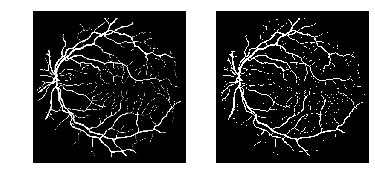

In [98]:
best = accuracy_list.index(max(accuracy_list))
f1 = plt.figure()
f1.add_subplot(1,2, 1)
plt.imshow(y_test[best].reshape((512,512)), cmap = 'gray')
plt.axis('off')
f1.add_subplot(1,2, 2)
plt.imshow(tmp[best].reshape((512,512)), cmap = 'gray')
plt.axis('off')
plt.show(block=True)